# **Estimación de la pose mediante regresión**

## Autores

* #### Alejandro Torres Rodríguez
* #### Javier Moreno Morón
* #### Ariel Terrón Rosas
* #### Iván Salinas López

# **0. Librerías**

In [1]:
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *
from fastdownload import FastDownload
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 556.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.4 MB/s eta 0:00:00
Mounted at /content/gdrive
fastcore version 1.5.29 installed
fastai version 2.7.13 installed
Mounted at /content/drive


# **1. Problema a resolver**

Este cuaderno incluye el código para la estimación de las coordenadas de 16 articulaciones del cuerpo humano. En este caso, se ha optado por realizar una regresión de 16 pares de coordenadas representando la posición de las articulaciones en la imagen. También se entrena un modelo que trata de realizar la estimación de un único punto de interés, la parte superior de la cabeza, para contrastar la eficacia de entrenar modelos separados para la estimación de cada uno de los puntos de interés. En este cuaderno restringiremos el problema a la estimación de la pose de con una única persona en la escena. Esto es así ya que, en caso de querer estimar la pose de múltiples personas en una sola imagen, una solución sería el uso de un modelo detector de personas en imágenes que se usase como primer paso y cuyo salida se usase para generar una escena con una única persona que se pasase como entrada al estimador de la pose.

# **2. Datos**

Esta sección del cuaderno contiene la descarga y procesado de los datos a utilizar para la estimación de las posiciones de articulaciones. El dataset a utilizar corresponde con el MPII Human Pose dataset. En concreto, de dicho dataset se utilizará la información referente a las anotaciones sobre las distintas personas en las imágenes que conforman el conjunto de datos.

## **2.1 Carga de datos**

In [2]:
download = False # Controla si se descargan los datos o no

In [3]:
# Descarga de las imágenes
if download:
    # Cambiamos al directorio local de cada uno
    %cd '/content/drive/MyDrive'

    data_url = 'https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz'

    # Descargamos los datos y los descomprimimos
    # Los datos comprimidos se guardan en fastai/downloaded
    # Los datos descomprimidos se guardan en fastai/extracted
    downloader = FastDownload(base='fastai', archive='downloaded', data='extracted')
    path = downloader.get(data_url, force=True)

    print(path)

    # Volvemos al directorio original
    %cd '/content'

In [4]:
# Descarga de las anotaciones
if download:
    # Cambiamos al directorio local de cada uno
    %cd '/content/drive/MyDrive'

    data_url = 'https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip'

    # Descargamos las anotaciones
    downloader = FastDownload(base='fastai', archive='downloaded', data='extracted')
    path = downloader.get(data_url, force=True)

    print(path)

    # Volvemos al directorio original
    %cd '/content'

## **2.2 Exploración de los datos**

Ahora extraeremos la información principal sobre las anotaciones referentes a las imágenes del dataset. Disponemos información sobre 16 articulaciones o puntos de interés del cuerpo humano, etiquetadas con los siguientes nombres: 
'r ankle','r knee','r hip','l hip','l knee','l ankle','pelvis','thorax','upper neck','head top','r wrist','r elbow','r shoulder','l shoulder','l elbow','l wrist'. De cada articulación disponemos de 3 datos:
    - Los dos primeros son las coordenadas de la articulación en la imagen.
    - Un tercer valor nos indica si la articulación es visible en la imagen (por ejemplo, una persona que sujete un objeto podría ocultar una parte de su cuerpo).

También disponemos de información en un campo llamado 'single person'. Este campo recoge la información sobre las distintas personas observardas en una misma imagen. Por ejemplo, en una imagen con dos personas el campo single person nos indicaría los identificadores de las anotaciones para las articulaciones de cada persona. Puesto que nuestro problema se restringe a una única persona, descartaremos imágenes con múltiples individuos. 

In [5]:
# Cargar el archivo .mat
datos_matlab = scipy.io.loadmat(
    '/content/drive/MyDrive/fastai/extracted/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat', \
    struct_as_record=False
)

In [6]:
release = vars(datos_matlab['RELEASE'][0,0])
annolist = release['annolist'][0]
img_train = release['img_train'][0]
single_person = release['single_person']
actlist = release['act']

In [7]:
nimages = annolist.size
data = pd.DataFrame()

JOINT_IDS = ['r ankle','r knee','r hip','l hip','l knee','l ankle','pelvis','thorax','upper neck','head top','r wrist','r elbow','r shoulder','l shoulder','l elbow','l wrist']

for imgidx in range(nimages):
  annotation = annolist[imgidx]
  train = img_train[imgidx]
  ridx = single_person[imgidx]
  act = vars(actlist[imgidx,0])

  filename = annotation.image[0,0].name[0]
  act_id = act['act_id'][0,0]

  fila_nueva = { }

  # filename, train and act type

  fila_nueva['file name'] = filename
  fila_nueva['img train'] = train
  fila_nueva['cat name'] = 'NaN'
  fila_nueva['act name'] = 'NaN'
  fila_nueva['act id'] = act_id

  if act_id != -1: fila_nueva['cat name'] = act['cat_name'][0]
  if act_id != -1: fila_nueva['act_name'] = act['act_name'][0]

  # joint data

  for id in JOINT_IDS:
    fila_nueva[id] = 'NaN'

  if annotation.annorect.size > 0: annorect = annotation.annorect[0]
  else: annorect = np.array([])
  if annorect.size == 1 and 'annopoints' in vars(annorect[0]):
    annopoints = annorect[0].annopoints[0,0].point[0]
    for joint in annopoints:
      xcoord = 'NaN'
      ycoord = 'NaN'
      is_visible = 'NaN'
      id = 'NaN'

      if 0 < joint.x.size: xcoord = joint.x[0,0]
      if 0 < joint.y.size: ycoord = joint.y[0,0]
      if 0 < joint.is_visible.size and len(joint.is_visible.shape) == 2: is_visible = joint.is_visible[0,0]
      elif 0 < joint.is_visible.size and len(joint.is_visible.shape) == 1: is_visible = joint.is_visible[0]
      if 0 < joint.id.size: id = JOINT_IDS[joint.id[0,0]]

      if id != 'NaN':
        fila_nueva[id] = (xcoord,ycoord,is_visible)

  data = pd.concat([data, pd.DataFrame([fila_nueva])], ignore_index=True)


In [8]:
data

,file name,img train,cat name,act name,act id,r ankle,r knee,r hip,l hip,l knee,l ankle,pelvis,thorax,upper neck,head top,r wrist,r elbow,r shoulder,l shoulder,l elbow,l wrist,act_name
0,037454012.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,095071431.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,073199394.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,059865848.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,015601864.jpg,1,sports,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24982,072772110.jpg,1,transportation,NaN,972,"(562, 617, 1)","(558, 539, 1)","(553, 452, 1)","(511, 458, 1)","(529, 536, 1)","(541, 610, 1)","(532, 455, 1)","(531, 378, 1)","(528.9869, 352.8365, NaN)","(525.0131, 303.1635, NaN)","(558, 411, 0)","(565, 393, 0)","(572, 377, 1)","(490, 378, 1)","(470, 411, 1)","(461, 414, 1)",pushing car
24983,039361034.jpg,1,transportation,NaN,972,"(496, 377, 1)","(466, 322, 1)","(510, 278, 0)","(540, 280, 1)","(558, 331, 1)","(596, 368, 1)","(525, 279, 0)","(454, 252, 0)","(451.3169, 251.4431, NaN)","(403.6831, 241.5569, NaN)","(378, 311, 0)","(404, 288, 1)","(441, 253, 0)","(466, 251, 1)","(436, 293, 1)","(410, 325, 1)",pushing car
24984,084761779.jpg,1,transportation,NaN,972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pushing car
24985,092025825.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train_data = data.loc[data['img train'] == 1]
activity_df = train_data.drop(['img train'] + JOINT_IDS, axis = 1)
joint_df = train_data.drop(['img train','cat name','act name','act id'], axis = 1)
joint_df = joint_df.reset_index(drop=True)

In [10]:
joint_df

,file name,r ankle,r knee,r hip,l hip,l knee,l ankle,pelvis,thorax,upper neck,head top,r wrist,r elbow,r shoulder,l shoulder,l elbow,l wrist,act_name
0,015601864.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
1,015599452.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
2,005808361.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
3,086617615.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
4,060111501.jpg,"(980, 322, 1)","(896, 318, 0)","(865, 248, 1)","(943, 226, 1)","(948, 290, 1)","(881, 349, 1)","(904, 237, 1)","(858, 135, 1)","(871.1877, 180.4244, NaN)","(835.8123, 58.5756, NaN)","(772, 294, 1)","(754, 247, 1)","(792, 147, 1)","(923, 123, 1)","(995, 163, 0)","(961, 223, 0)",curling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18074,033474347.jpg,"(876, 461, 1)","(815, 380, 1)","(779, 296, 1)","(742, 303, 1)","(706, 386, 1)","(739, 468, 1)","(761, 300, 1)","(684, 219, 0)","(671.7848, 204.2324, NaN)","(629.2152, 152.7676, NaN)","(693, 243, 0)","(726, 260, 0)","(704, 214, 0)","(663, 223, 1)","(674, 286, 1)","(631, 260, 1)",pushing car
18075,082650067.jpg,"(1038, 656, 1)","(950, 504, 1)","(903, 328, 1)","(831, 337, 1)","(811, 504, 1)","(853, 637, 1)","(867, 333, 1)","(775, 212, 0)","(762.9653, 196.7913, NaN)","(696.0347, 112.2087, NaN)","(815, 236, 0)","(864, 273, 0)","(821, 204, 0)","(729, 220, 1)","(704, 332, 1)","(675, 269, 1)",pushing car
18076,072772110.jpg,"(562, 617, 1)","(558, 539, 1)","(553, 452, 1)","(511, 458, 1)","(529, 536, 1)","(541, 610, 1)","(532, 455, 1)","(531, 378, 1)","(528.9869, 352.8365, NaN)","(525.0131, 303.1635, NaN)","(558, 411, 0)","(565, 393, 0)","(572, 377, 1)","(490, 378, 1)","(470, 411, 1)","(461, 414, 1)",pushing car
18077,039361034.jpg,"(496, 377, 1)","(466, 322, 1)","(510, 278, 0)","(540, 280, 1)","(558, 331, 1)","(596, 368, 1)","(525, 279, 0)","(454, 252, 0)","(451.3169, 251.4431, NaN)","(403.6831, 241.5569, NaN)","(378, 311, 0)","(404, 288, 1)","(441, 253, 0)","(466, 251, 1)","(436, 293, 1)","(410, 325, 1)",pushing car


## **2.3 Preprocesado**

En el preprocesado de datos, eliminaremos aquellas filas de datos en las que, por motivos referentes al dataset escogido, las posiciones de las articulaciones no estén definidas. Al tener que realizar la regresión de 32 pares de coordenadas, optaremos por eliminar aquellas entradas que contengan alguna inconsistencia en algunas de las articulaciones.

In [11]:
df = pd.DataFrame()
for i,row in joint_df.iterrows():
  drop = True
  for id in JOINT_IDS:
    if row[id] != 'NaN':
      drop = False
      break

  if drop: # drop rows with all joint 'NaN'
    continue

  new_row = {}
  new_row['file name'] = row['file name']
  for id in JOINT_IDS:
    joint = row[id]
    if pd.isna(joint) or joint == 'NaN':
      new_row[id + ' xcoord'] = -1.0
      new_row[id + ' ycoord'] = -1.0
    else:
      new_row[id + ' xcoord'] = joint[0]
      new_row[id + ' ycoord'] = joint[1]

  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [12]:
df

,file name,r ankle xcoord,r ankle ycoord,r knee xcoord,r knee ycoord,r hip xcoord,r hip ycoord,l hip xcoord,l hip ycoord,l knee xcoord,l knee ycoord,l ankle xcoord,l ankle ycoord,pelvis xcoord,pelvis ycoord,thorax xcoord,thorax ycoord,upper neck xcoord,upper neck ycoord,head top xcoord,head top ycoord,r wrist xcoord,r wrist ycoord,r elbow xcoord,r elbow ycoord,r shoulder xcoord,r shoulder ycoord,l shoulder xcoord,l shoulder ycoord,l elbow xcoord,l elbow ycoord,l wrist xcoord,l wrist ycoord
0,060111501.jpg,980.0,322.0,896.0,318.0,865.0,248.0,943.0,226.0,948.0,290.0,881.0,349.0,904.0,237.0,858.0,135.0,871.1877,180.4244,835.8123,58.5756,772.0,294.0,754.0,247.0,792.0,147.0,923.0,123.0,995.0,163.0,961.0,223.0
1,002058449.jpg,918.0,456.0,659.0,518.0,713.0,413.0,979.0,288.0,1222.0,453.0,974.0,399.0,846.0,351.0,738.0,259.0,795.2738,314.8937,597.7262,122.1063,441.0,490.0,446.0,434.0,599.0,270.0,877.0,247.0,1112.0,384.0,1012.0,489.0
2,029122914.jpg,-1.0,-1.0,301.0,473.0,302.0,346.0,362.0,345.0,367.0,470.0,-1.0,-1.0,332.0,346.0,325.0,217.0,326.2681,196.1669,330.7319,122.8331,275.0,299.0,262.0,300.0,278.0,220.0,371.0,213.0,396.0,309.0,393.0,290.0
3,061185289.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,533.0,322.0,515.0945,277.1333,463.9055,148.8667,353.0,172.0,426.0,239.0,513.0,288.0,552.0,355.0,-1.0,-1.0,-1.0,-1.0
4,013949386.jpg,-1.0,-1.0,-1.0,-1.0,110.0,385.0,208.0,355.0,-1.0,-1.0,-1.0,-1.0,159.0,370.0,189.0,228.0,191.1195,227.0916,326.8805,168.9084,367.0,363.0,254.0,429.0,166.0,303.0,212.0,153.0,319.0,123.0,376.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11426,050240222.jpg,607.0,689.0,599.0,542.0,605.0,416.0,691.0,410.0,704.0,555.0,714.0,704.0,648.0,413.0,599.0,230.0,595.1375,204.3532,577.8625,89.6468,418.0,305.0,472.0,281.0,534.0,232.0,663.0,228.0,623.0,289.0,555.0,333.0
11427,033474347.jpg,876.0,461.0,815.0,380.0,779.0,296.0,742.0,303.0,706.0,386.0,739.0,468.0,761.0,300.0,684.0,219.0,671.7848,204.2324,629.2152,152.7676,693.0,243.0,726.0,260.0,704.0,214.0,663.0,223.0,674.0,286.0,631.0,260.0
11428,082650067.jpg,1038.0,656.0,950.0,504.0,903.0,328.0,831.0,337.0,811.0,504.0,853.0,637.0,867.0,333.0,775.0,212.0,762.9653,196.7913,696.0347,112.2087,815.0,236.0,864.0,273.0,821.0,204.0,729.0,220.0,704.0,332.0,675.0,269.0
11429,072772110.jpg,562.0,617.0,558.0,539.0,553.0,452.0,511.0,458.0,529.0,536.0,541.0,610.0,532.0,455.0,531.0,378.0,528.9869,352.8365,525.0131,303.1635,558.0,411.0,565.0,393.0,572.0,377.0,490.0,378.0,470.0,411.0,461.0,414.0


In [13]:
columns = df.columns[1:]
joint_df = df[~(df == -1.0).any(axis=1)]
joint_df

,file name,r ankle xcoord,r ankle ycoord,r knee xcoord,r knee ycoord,r hip xcoord,r hip ycoord,l hip xcoord,l hip ycoord,l knee xcoord,l knee ycoord,l ankle xcoord,l ankle ycoord,pelvis xcoord,pelvis ycoord,thorax xcoord,thorax ycoord,upper neck xcoord,upper neck ycoord,head top xcoord,head top ycoord,r wrist xcoord,r wrist ycoord,r elbow xcoord,r elbow ycoord,r shoulder xcoord,r shoulder ycoord,l shoulder xcoord,l shoulder ycoord,l elbow xcoord,l elbow ycoord,l wrist xcoord,l wrist ycoord
0,060111501.jpg,980.0,322.0,896.0,318.0,865.0,248.0,943.0,226.0,948.0,290.0,881.0,349.0,904.0,237.0,858.0,135.0,871.1877,180.4244,835.8123,58.5756,772.0,294.0,754.0,247.0,792.0,147.0,923.0,123.0,995.0,163.0,961.0,223.0
1,002058449.jpg,918.0,456.0,659.0,518.0,713.0,413.0,979.0,288.0,1222.0,453.0,974.0,399.0,846.0,351.0,738.0,259.0,795.2738,314.8937,597.7262,122.1063,441.0,490.0,446.0,434.0,599.0,270.0,877.0,247.0,1112.0,384.0,1012.0,489.0
6,036636184.jpg,525.0,478.0,529.0,369.0,517.0,220.0,570.0,204.0,574.0,371.0,581.0,480.0,544.0,212.0,488.0,76.0,479.0873,71.5436,392.9127,28.4564,416.0,251.0,469.0,201.0,459.0,104.0,516.0,48.0,588.0,132.0,587.0,242.0
7,045606998.jpg,555.0,370.0,568.0,298.0,559.0,255.0,645.0,140.0,600.0,343.0,610.0,480.0,602.0,198.0,515.0,179.0,508.3448,181.3768,395.6552,221.6232,495.0,361.0,470.0,285.0,464.0,170.0,566.0,187.0,671.0,230.0,591.0,316.0
11,060754485.jpg,694.0,684.0,685.0,579.0,670.0,437.0,747.0,421.0,751.0,574.0,768.0,717.0,709.0,429.0,649.0,230.0,642.6337,217.5659,591.3663,117.4341,488.0,351.0,551.0,307.0,600.0,242.0,698.0,217.0,767.0,310.0,790.0,405.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11426,050240222.jpg,607.0,689.0,599.0,542.0,605.0,416.0,691.0,410.0,704.0,555.0,714.0,704.0,648.0,413.0,599.0,230.0,595.1375,204.3532,577.8625,89.6468,418.0,305.0,472.0,281.0,534.0,232.0,663.0,228.0,623.0,289.0,555.0,333.0
11427,033474347.jpg,876.0,461.0,815.0,380.0,779.0,296.0,742.0,303.0,706.0,386.0,739.0,468.0,761.0,300.0,684.0,219.0,671.7848,204.2324,629.2152,152.7676,693.0,243.0,726.0,260.0,704.0,214.0,663.0,223.0,674.0,286.0,631.0,260.0
11428,082650067.jpg,1038.0,656.0,950.0,504.0,903.0,328.0,831.0,337.0,811.0,504.0,853.0,637.0,867.0,333.0,775.0,212.0,762.9653,196.7913,696.0347,112.2087,815.0,236.0,864.0,273.0,821.0,204.0,729.0,220.0,704.0,332.0,675.0,269.0
11429,072772110.jpg,562.0,617.0,558.0,539.0,553.0,452.0,511.0,458.0,529.0,536.0,541.0,610.0,532.0,455.0,531.0,378.0,528.9869,352.8365,525.0131,303.1635,558.0,411.0,565.0,393.0,572.0,377.0,490.0,378.0,470.0,411.0,461.0,414.0


In [14]:
# Dividir el DataFrame en conjuntos de entrenamiento y test
df_train, df_test = train_test_split(joint_df, test_size=0.2, random_state=42)

In [15]:
df_train

,file name,r ankle xcoord,r ankle ycoord,r knee xcoord,r knee ycoord,r hip xcoord,r hip ycoord,l hip xcoord,l hip ycoord,l knee xcoord,l knee ycoord,l ankle xcoord,l ankle ycoord,pelvis xcoord,pelvis ycoord,thorax xcoord,thorax ycoord,upper neck xcoord,upper neck ycoord,head top xcoord,head top ycoord,r wrist xcoord,r wrist ycoord,r elbow xcoord,r elbow ycoord,r shoulder xcoord,r shoulder ycoord,l shoulder xcoord,l shoulder ycoord,l elbow xcoord,l elbow ycoord,l wrist xcoord,l wrist ycoord
9769,098936464.jpg,1541.0,619.0,1483.0,436.0,1578.0,221.0,1575.0,281.0,1489.0,481.0,1570.0,690.0,1577.0,251.0,1320.0,215.0,1304.2693,217.5423,1137.7307,244.4577,1392.0,213.0,1421.0,169.0,1339.0,148.0,1300.0,281.0,1185.0,355.0,1022.0,397.0
757,019186732.jpg,907.0,872.0,911.0,711.0,911.0,528.0,1010.0,528.0,1022.0,708.0,1034.0,913.0,961.0,528.0,987.0,229.0,984.1856,213.7479,958.8144,76.2521,842.0,369.0,871.0,398.0,885.0,254.0,1089.0,203.0,1138.0,364.0,1063.0,333.0
10124,095154215.jpg,286.0,904.0,426.0,612.0,662.0,364.0,652.0,370.0,417.0,649.0,296.0,953.0,657.0,367.0,926.0,496.0,949.3935,474.5668,723.6065,681.4332,1034.0,932.0,1025.0,736.0,944.0,494.0,907.0,497.0,969.0,807.0,975.0,1053.0
1002,016470635.jpg,429.0,357.0,400.0,301.0,377.0,237.0,329.0,242.0,330.0,293.0,315.0,342.0,353.0,240.0,355.0,194.0,355.6028,195.5344,343.3972,164.4656,410.0,231.0,411.0,193.0,384.0,187.0,325.0,201.0,329.0,239.0,341.0,277.0
2313,077804631.jpg,831.0,498.0,824.0,405.0,809.0,274.0,888.0,278.0,882.0,407.0,882.0,480.0,849.0,276.0,863.0,123.0,869.6368,109.1002,909.3632,25.8998,846.0,276.0,797.0,203.0,802.0,94.0,924.0,152.0,915.0,245.0,920.0,329.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,070334095.jpg,1293.0,1033.0,1228.0,807.0,1152.0,554.0,1036.0,581.0,1048.0,874.0,1051.0,1070.0,1094.0,568.0,963.0,273.0,952.7744,224.9397,923.2256,86.0603,1286.0,483.0,1183.0,340.0,1064.0,230.0,862.0,315.0,767.0,386.0,813.0,352.0
8389,010470516.jpg,436.0,406.0,484.0,279.0,421.0,172.0,401.0,184.0,465.0,278.0,456.0,390.0,411.0,178.0,485.0,79.0,487.1186,79.4802,557.8814,95.5198,502.0,174.0,470.0,89.0,487.0,55.0,483.0,102.0,453.0,131.0,432.0,166.0
8425,025696885.jpg,612.0,546.0,625.0,474.0,619.0,375.0,654.0,375.0,681.0,464.0,680.0,541.0,637.0,375.0,646.0,284.0,650.1736,273.2499,674.8264,209.7501,603.0,418.0,593.0,352.0,609.0,285.0,683.0,283.0,693.0,341.0,705.0,394.0
8629,038669149.jpg,1714.0,814.0,1668.0,779.0,1673.0,722.0,1674.0,722.0,1661.0,769.0,1652.0,817.0,1674.0,722.0,1672.0,655.0,1667.5129,640.9270,1654.4871,600.0730,1674.0,710.0,1677.0,676.0,1674.0,647.0,1670.0,663.0,1676.0,692.0,1668.0,732.0


# **3. Entrenamiento**

Esta sección contienen el código referente a la creación y entrenamiento de los modelos para la estimación de la pose. Entrenaremos un modelo para realizar la regresión de las 16 articulaciones como un vector de 32 coordenadas y otro modelo con la estimación de la parte superior de la cabeza. En ambos modelos normalizaremos las coordenadas al rango [0,1] tanto en ambas dimensiones. También aplicaremos normalización basada en ImageNet a las imágenes en ambos modelos. Escalaremos las imágenes a un tamaño de 256x256 para la entrada del modelo.

Respecto a las funciones de pérdida y métricas que usaremos, estas serán MSE (Mean Squared Error) y MAE (Mean Absolute Error) respectivamente. En ambos casos usaremos como base para el modelo ResNet18 y realizaremos *fine tune* con los pesos congelados durante una época para observar el ajuste inicial del modelo al problema.

Para la elección inicial del *learning rate* para nuestro modelo usaremos la funcionalidad *lr_find* de fastai quedándonos con el valor que maximice la pendiente de la función de pérdida.

In [16]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# **3.1 Estimación de la pose mediante regresión directa de 16 pares de coordenadas**

### **3.1.1 Creación del Datablock**

In [17]:
path = '/content/drive/MyDrive/fastai/extracted/mpii_human_pose_v1/'

image_resize_size = 256

batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

def get_pos_scale(o):
  file_name = o[0]
  im = cv2.imread( path + file_name)

  img_size_original = im.shape

  scale_factor_x = 1 / img_size_original[1]
  scale_factor_y = 1 / img_size_original[0]

  scaled_points = []

  for i in range(1,len(o),2):
    if o[i] == -1.0 or o[i+1] == -1.0:
      scaled_points.append(-1.0)
      scaled_points.append(-1.0)
    else:
      scaled_points.append(o[i] * scale_factor_x)
      scaled_points.append(o[i+1] * scale_factor_y)

  return scaled_points

dls_joint = DataBlock(
    blocks=(ImageBlock, RegressionBlock(n_out=len(JOINT_IDS) * 2)),
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_x=ColReader("file name", pref=path),
    get_y=Pipeline([ColReader(df_train.columns), get_pos_scale]),
    item_tfms=Resize(image_resize_size),
    batch_tfms=batch_tfms,
).dataloaders(df_train, bs=32)

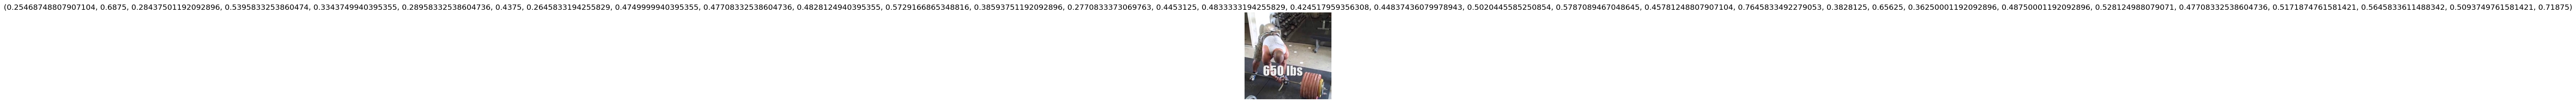

In [18]:
dls_joint.show_batch(nrows=1, ncols=1)

### **3.1.2 Entrenamiento**

In [19]:
learner = cnn_learner(dls_joint, models.resnet18, loss_func=MSELossFlat(), metrics=mae)
learner.summary()

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

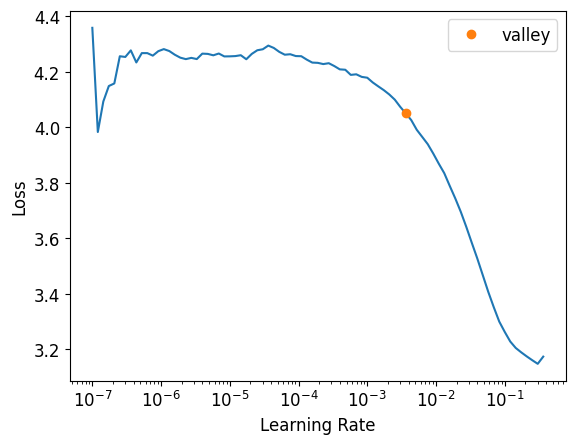

In [20]:
lr = learner.lr_find().valley

In [21]:
learner.fine_tune(epochs=5, base_lr=lr, freeze_epochs=1)

epoch,train_loss,valid_loss,mae,time
0,1.240832,0.121203,0.274848,10:25


epoch,train_loss,valid_loss,mae,time
0,0.154840,0.037351,0.152491,03:51
1,0.046353,0.023300,0.117853,03:51
2,0.031631,0.020691,0.110667,03:52
3,0.023895,0.014140,0.088656,03:49
4,0.019167,0.012654,0.083021,03:50


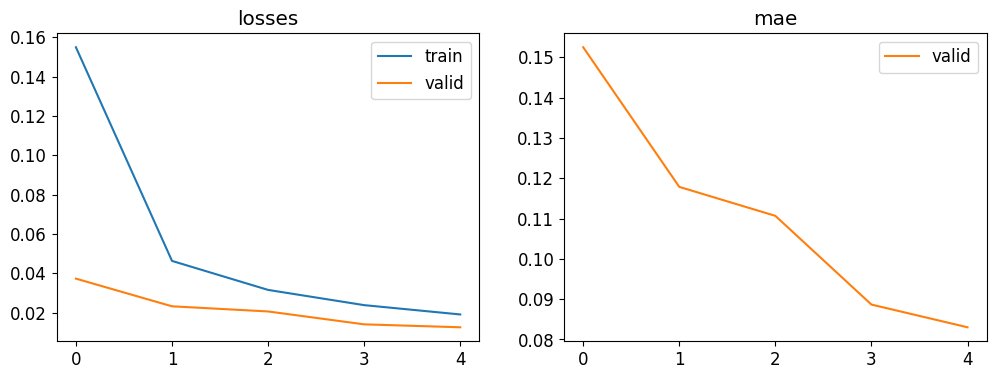

In [22]:
learner.recorder.plot_metrics()

Como vemos en las curvas de aprendizaje, el modelo presenta un comportamiento adecueado respecto al aprendizaje. La pérdida en entrenamiento y en validación se acercan y avanzan a un ritmo similar, además de estar razonablemente cerca. Esto nos indica que no hay problemas de sobreajuste. Si observamos la métrica escogida, el MAE, vemos que alcanza su mínimo en 0.08. Sobre un valor total de 1.0, esto nos indica que podemos esperar alrededor de un 10% de error sobre las dimensiones de la imagen.

# **3.2 Estimación de la posición de la parte superior de la cabeza mediante regresión**

En este apartado seguiremos los pasos del anterior, reduciendo la complejidad del problema a un solo punto de interés. Con esto, esperamos ver si la fuente de los problemas en el apartado anterior es fruto de las interacciones entre múltiples articulaciones o si por el contrario el enfoque escogido es insuficiente para obtener buenos resultados.

## **3.2.1 Creación del conjunto de datos y datablock**

In [23]:
head_df = joint_df[['file name','head top xcoord','head top ycoord']]
head_df

,file name,head top xcoord,head top ycoord
0,060111501.jpg,835.8123,58.5756
1,002058449.jpg,597.7262,122.1063
6,036636184.jpg,392.9127,28.4564
7,045606998.jpg,395.6552,221.6232
11,060754485.jpg,591.3663,117.4341
...,...,...,...
11426,050240222.jpg,577.8625,89.6468
11427,033474347.jpg,629.2152,152.7676
11428,082650067.jpg,696.0347,112.2087
11429,072772110.jpg,525.0131,303.1635


In [24]:
df_train_head, df_test_head = train_test_split(head_df, test_size=0.2, random_state=42)
df_train_head

,file name,head top xcoord,head top ycoord
9769,098936464.jpg,1137.7307,244.4577
757,019186732.jpg,958.8144,76.2521
10124,095154215.jpg,723.6065,681.4332
1002,016470635.jpg,343.3972,164.4656
2313,077804631.jpg,909.3632,25.8998
...,...,...,...
6200,070334095.jpg,923.2256,86.0603
8389,010470516.jpg,557.8814,95.5198
8425,025696885.jpg,674.8264,209.7501
8629,038669149.jpg,1654.4871,600.0730


In [25]:
path = '/content/drive/MyDrive/fastai/extracted/mpii_human_pose_v1/'

image_resize_size = 256

batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

def get_pos_scale(o):
  file_name = o[0]
  im = cv2.imread(path + file_name)

  img_size_original = im.shape

  scale_factor_x = 1 / img_size_original[1]
  scale_factor_y = 1 / img_size_original[0]

  scaled_points = []

  for i in range(1,len(o),2):
    if o[i] == -1.0 or o[i+1] == -1.0:
      scaled_points.append(-1.0)
      scaled_points.append(-1.0)
    else:
      scaled_points.append(o[i] * scale_factor_x)
      scaled_points.append(o[i+1] * scale_factor_y)

  return scaled_points

dls_head = DataBlock(
    blocks=(ImageBlock, RegressionBlock(n_out=2)),
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_x=ColReader("file name", pref=path),
    get_y=Pipeline([ColReader(df_train_head.columns), get_pos_scale]),
    item_tfms=Resize(image_resize_size),
    batch_tfms=batch_tfms,
).dataloaders(df_train_head, bs=32)

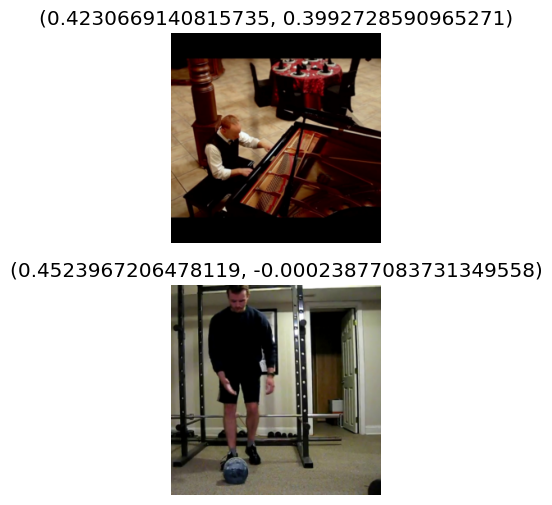

In [26]:
dls_head.show_batch(nrows=2,ncols=1)

## **3.2.2 Entrenamiento**

In [27]:
learner_head = cnn_learner(dls_head, models.resnet18, loss_func=MSELossFlat(), metrics=mae)
learner_head.summary()

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

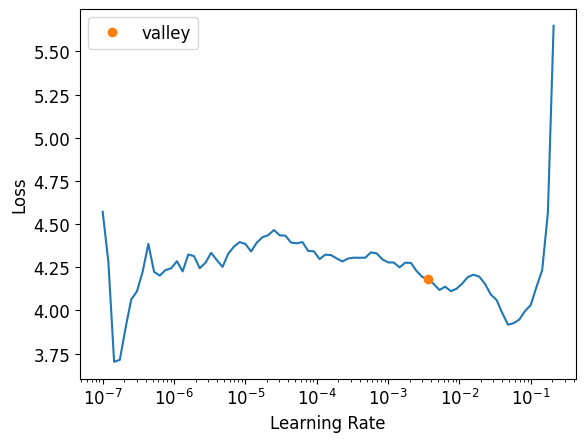

In [28]:
lr = learner_head.lr_find().valley

In [29]:
learner_head.fine_tune(epochs=5, base_lr=lr, freeze_epochs=1)

epoch,train_loss,valid_loss,mae,time
0,1.286496,0.151686,0.308930,03:39


epoch,train_loss,valid_loss,mae,time
0,0.115828,0.040297,0.154138,03:40
1,0.051902,0.027583,0.128861,03:40
2,0.035265,0.019173,0.104839,03:41
3,0.022846,0.014028,0.087258,03:41
4,0.017517,0.012680,0.082233,03:40


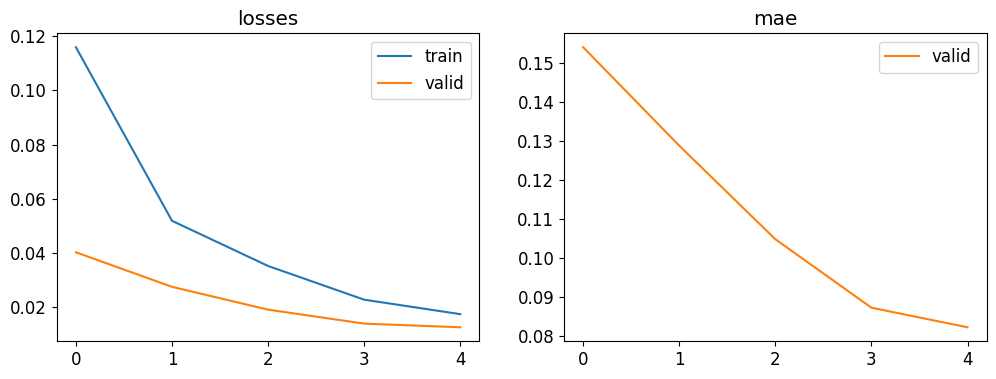

In [30]:
learner_head.recorder.plot_metrics()

El comportamiento de este experimento es muy similar al anterior, por lo que deducimos que la cantida de puntos a predecir no supone un problema. Solo queda probar los modelos con imágenes y observar la calidad de los resultados.

# **4. Resultados**

Para comprobar la calidad de los resultados observaremos las medidas obtenidas por los modelos en el conjunto de test y también realizaremos una prueba visual sobre una imagen dibujando la pose estimada sobre la imagen.

In [54]:
def draw_skeleton(img, joint_coords):
    connections = [
        ('head top', 'upper neck', (0, 0, 255)),
        ('upper neck', 'r shoulder', (0, 0, 255)),
        ('upper neck', 'l shoulder', (0, 0, 255)),
        ('r shoulder', 'r elbow', (0, 0, 255)),
        ('r elbow', 'r wrist', (0, 0, 255)),
        ('l shoulder', 'l elbow', (0, 0, 255)),
        ('l elbow', 'l wrist', (0, 0, 255)),
        ('upper neck', 'thorax', (0, 0, 255)),
        ('thorax', 'pelvis', (0, 0, 255)),
        ('pelvis', 'r hip', (0, 0, 255)),
        ('r hip', 'r knee', (0, 0, 255)),
        ('r knee', 'r ankle', (0, 0, 255)),
        ('pelvis', 'l hip', (0, 0, 255)),
        ('l hip', 'l knee', (0, 0, 255)),
        ('l knee', 'l ankle', (0, 0, 255))
    ]

    for joint_start, joint_end, color in connections:
        if 0 <= joint_coords[joint_start][0] and 0 <= joint_coords[joint_start][1] and 0 <= joint_coords[joint_end][0] and 0 <= joint_coords[joint_end][1]:
            cv2.line(img, joint_coords[joint_start], joint_coords[joint_end], color, 2)

## **4.1 Test**

Como se observa en las celdas inferiores, las medidas en test corresponden con las de entrenamiento. Esto era de esperar, pues las curvas de aprendizaje de los modelos presentaban comportamientos correcto que no indicaban nigún problema en el aprendizaje.

### **4.1.1 Test Pose Completa**

In [43]:
test_dl = learner.dls.test_dl(df_test,with_labels=True)

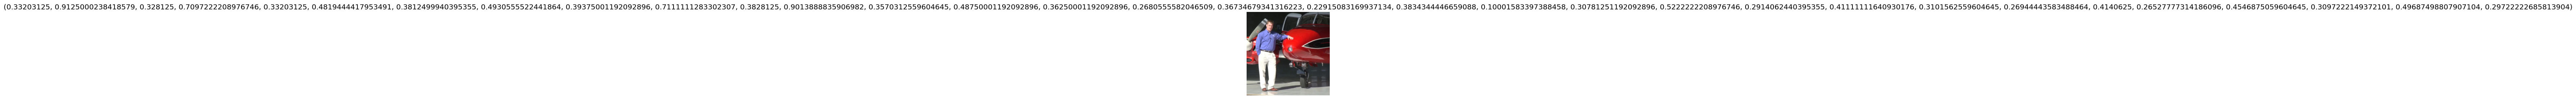

In [44]:
test_dl.show_batch(nrows=1,ncols=1)

In [45]:
learner.model.eval()
test_predictions, test_targets = learner.get_preds(dl=test_dl)

In [49]:
print(f'Test Loss (MSE): {mse(test_predictions,test_targets).numpy()}')
print(f'Test Metric (MAE): {mae(test_predictions,test_targets).numpy()}')

Test Loss (MSE): 0.0126950116828084
Test Metric (MAE): 0.08346080034971237


### **4.1.2 Test Posición Cabeza**

In [50]:
test_head_dl = learner_head.dls.test_dl(df_test_head,with_labels=True)

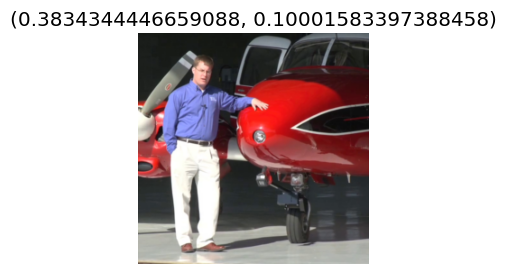

In [51]:
test_head_dl.show_batch(nrows=1,ncols=1)

In [52]:
learner_head.model.eval()
test_predictions_head, test_targets_head = learner_head.get_preds(dl=test_head_dl)

In [53]:
print(f'Test Loss (MSE): {mse(test_predictions_head,test_targets_head).numpy()}')
print(f'Test Metric (MAE): {mae(test_predictions_head,test_targets_head).numpy()}')

Test Loss (MSE): 0.013224536553025246
Test Metric (MAE): 0.08275771886110306


## **Pruebas visuales de los predictores**

In [68]:
test_index = 512
test_example = df_test.iloc[test_index]
file_name = test_example['file name']

true_coords = {}
for id in JOINT_IDS:
  xcoord = int(test_example[id + ' xcoord'])
  ycoord = int(test_example[id + ' ycoord'])
  coords = (xcoord,ycoord)
  true_coords[id] = coords

test_image = cv2.cvtColor(cv2.imread(path + file_name),cv2.COLOR_BGR2RGB)

joint_pred = np.array(learner.predict(test_image)[0])
head_pred = np.array(learner_head.predict(test_image)[0])

In [69]:
predicted_coords = {}
for i,id in enumerate(JOINT_IDS):
  x = int(joint_pred[i] * test_image.shape[1])
  y = int(joint_pred[i+1] * test_image.shape[0])
  predicted_coords[id] = (x,y)

head_pred[0] = int(head_pred[0] * test_image.shape[1])
head_pred[1] = int(head_pred[1] * test_image.shape[0])
head_pred = head_pred.astype(int)

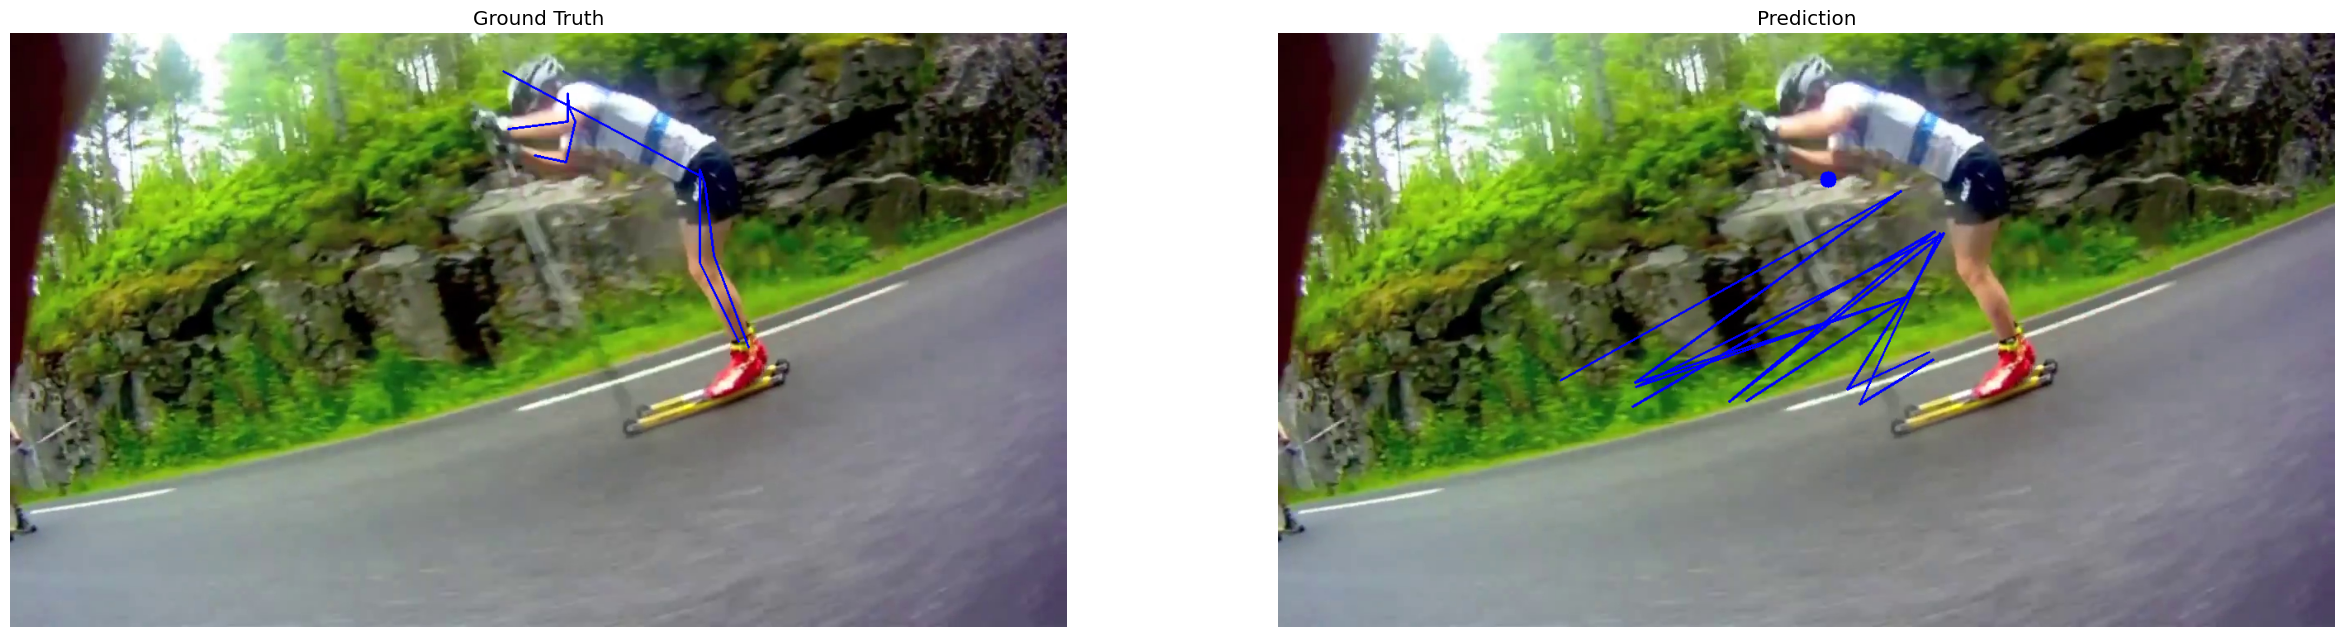

In [70]:
prediction_image = test_image.copy()

draw_skeleton(test_image,true_coords)
draw_skeleton(prediction_image,predicted_coords)
cv2.circle(prediction_image,head_pred,10,(0,0,255),thickness=-1)

plt.figure(figsize=(30,20))

plt.subplot(1,2,1)
plt.imshow(test_image)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(prediction_image)
plt.title('Prediction')
plt.axis('off')

plt.show()

Observando los resultados arrojados por los predictores en las estimaciones vemos que, aunque los errores numericos (MAE) no son especialmente elevados el resultado final es incorrecto ya que el predictor no consigue establecer una buena relación entre los distintos puntos claves de la pose. Si bien la predicción se acerca a la localización de la persona en la imagen, dista mucho de un resultado satisfactorio.